In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from models.fno2d import FNO2d
from gen_GRF import gaussian_random_field

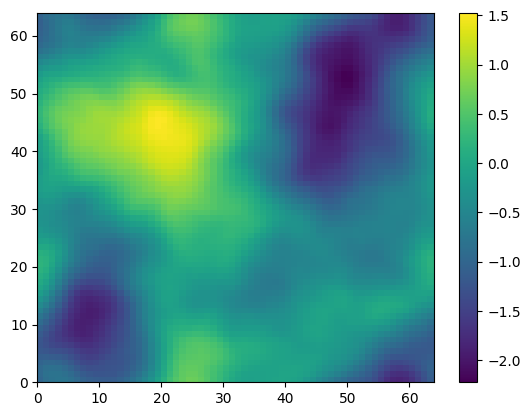

In [2]:
s = 2
sample = gaussian_random_field(s)

plt.figure()
plt.pcolor(sample[0])
plt.colorbar()
plt.show()

In [3]:
# get GRF data
def generate_GRF_data(s_vals=[0.5, 1.0, 1.5, 2.0],
                      sizes = [32, 64, 128, 256], #, 512, 1024, 2048],
                      sample_count = 32):
    '''
    Output is a dictionary which can be accessed via
    grf_data[s][size] --> tensor of shape [sample_count, 1, size, size]
    '''
    grf_data = {} # dicationary
    
    for s in s_vals:
        # generate all GRFs for this smoothness value
        grf_samples = {size: torch.zeros(sample_count,1,size,size) for size in sizes}
        for i in range(sample_count):
            # one sample at different resolutions
            one_sample = gaussian_random_field(s, sizes) 
            for id,size in enumerate(sizes):
                grf_samples[size][i,0,:,:] = one_sample[id]
        # collect
        grf_data[s] = grf_samples

    # add info
    grf_data['s_vals'] = s_vals
    grf_data['sizes'] = sizes
    grf_data['sample_count'] = sample_count
    
    return grf_data

grf_data = generate_GRF_data()
        


In [4]:
# # Plot GRFs
# s_vals = grf_data['s_vals']
# sizes = grf_data['sizes']

# fig, ax = plt.subplots(4, 6, figsize=(30, 15))
# for i, s in enumerate(s_vals):
#     for j, size in enumerate(sizes[:-1]):
#         Z = pkl.load(open("../data/GRF_s"+  str(s) + "_GRF_size_" + str(size) + "_0.pkl", "rb"))
#         ax[i, j].imshow(Z, cmap='viridis')
#         ax[i, j].set_title("s = " + str(s) + " size = " + str(size))
#         ax[i, j].axis('off')

In [5]:
#from eval_model_helpers import *
import sys, os
sys.path.append(os.path.join('..'))
#from models.func_to_func2d_invasive import FNO2d

#from util.utilities_module import *
from gen_GRF import *
import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [6]:
def weights_all_ones(model):
    sd = model.state_dict()
    for k in sd.keys():
        sd[k] = torch.ones_like(sd[k])
    model.load_state_dict(sd)
    return model

def weights_x10(model):
    sd = model.state_dict()
    for k in sd.keys():
        sd[k] = 10*sd[k]
    model.load_state_dict(sd)
    return model

grid.shape=torch.Size([2, 32, 32])


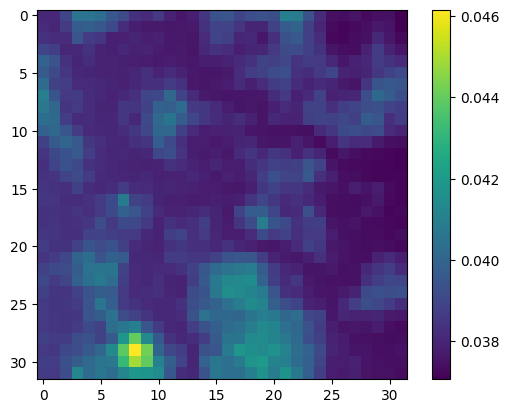

grid.shape=torch.Size([2, 64, 64])


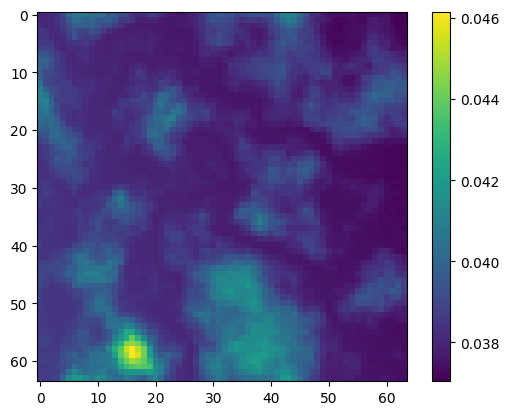

grid.shape=torch.Size([2, 128, 128])


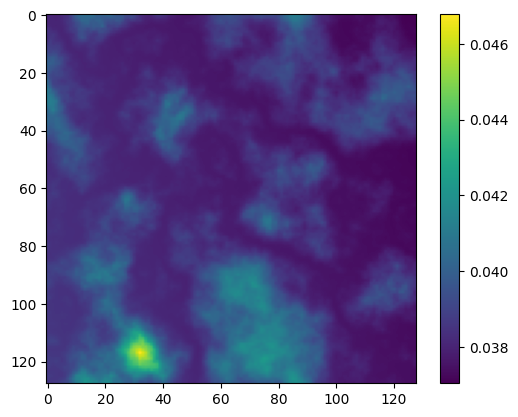

grid.shape=torch.Size([2, 256, 256])


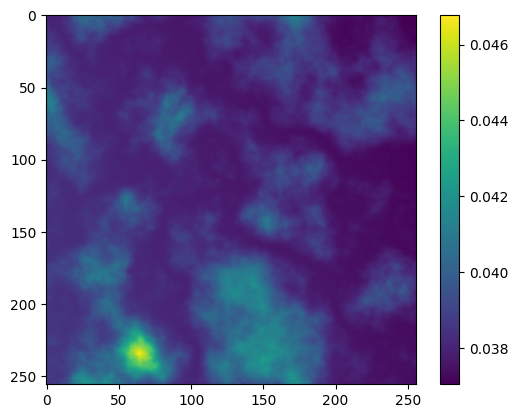

In [7]:
# check the discretization-inveriance visually
modes = 16
width = 32
in_channels = 1
out_channels = 1
which_grid = 'xy'
model = FNO2d(modes,width,in_channels,out_channels,which_grid=which_grid)

s = 1.0
sizes = grf_data['sizes']
for size in sizes:
    x = grf_data[s][size].view(-1,1,size,size)
    pred = model(x).detach().squeeze()
    plt.figure()
    plt.imshow(pred[0])
    plt.colorbar()
    plt.show()
    

In [8]:
modes = 16
width = 32
in_channels = 1
out_channels = 1
which_grid = 'periodic'

# Initialize all random models
models = {}

# model with different initializations and GeLU activation
which_grid = None
models['normal'] = FNO2d(modes,width,in_channels,out_channels,which_grid=which_grid)
models['normal_x10'] = weights_x10(
    FNO2d(modes,width,in_channels,out_channels,which_grid=which_grid)
)
models['all_ones'] = weights_all_ones(
    FNO2d(modes,width,in_channels,out_channels,which_grid=which_grid)
)

# model with ReLU activation
which_grid = None
models['normal_relu'] = FNO2d(modes,width,in_channels,out_channels,which_grid=which_grid, act='relu')

# model with GeLU and xy grid
which_grid = 'xy'
models['normal_xygrid'] = FNO2d(modes,width,in_channels,out_channels,which_grid=which_grid, act='relu')

# model with GeLU and periodic grid
which_grid = 'periodic'
models['normal_periodic'] = FNO2d(modes,width,in_channels,out_channels,which_grid=which_grid, act='relu')


In [28]:
def get_layer_outputs(model, samples):
    '''
    Input: model
           samples: dictionary of tensor inputs with keys==sizes
                    samples[size] of shape (B,C,size,size)
    '''
    sizes = samples.keys()

    # get layer outputs for each size
    layer_outputs = {}
    for size in sizes:
        x = samples[size]
        x = x.view(-1,1,size,size)
        layer_outputs[size] = model.layer_outputs(x)
        
    return layer_outputs


################################################################
#
# 1d helpers
#
################################################################
def resize_rfft(ar, s):
    """
    Truncates or zero pads the highest frequencies of ``ar'' such that torch.fft.irfft(ar, n=s) is either an interpolation to a finer grid or a subsampling to a coarser grid.
    Args
        ar: (..., N) tensor, must satisfy real conjugate symmetry (not checked)
        s: (int), desired irfft output dimension >= 1
    Output
        out: (..., s//2 + 1) tensor
    """
    N = ar.shape[-1]
    # pdb.set_trace()
    s = s//2 + 1 if s >=1 else s//2
    if s >= N: # zero pad or leave alone
        out = torch.zeros(list(ar.shape[:-1]) + [s - N], dtype=torch.cfloat, device=ar.device)
        out = torch.cat((ar[..., :N], out), dim=-1)
    elif s >= 1: # truncate
        out = ar[..., :s]
    else: # edge case
        raise ValueError("s must be greater than or equal to 1.")

    return out


def resize_fft(ar, s):
    """
    Truncates or zero pads the highest frequencies of ``ar'' such that torch.fft.ifft(ar, n=s) is either an interpolation to a finer grid or a subsampling to a coarser grid.
    Reference: https://github.com/numpy/numpy/pull/7593
    Args
        ar: (..., N) tensor
        s: (int), desired ifft output dimension >= 1
    Output
        out: (..., s) tensor
    """
    N = ar.shape[-1]
    if s >= N: # zero pad or leave alone
        out = torch.zeros(list(ar.shape[:-1]) + [s - N], dtype=torch.cfloat, device=ar.device)
        out = torch.cat((ar[..., :N//2], out, ar[..., N//2:]), dim=-1)
    elif s >= 2: # truncate modes
        if s % 2: # odd
            out = torch.cat((ar[..., :s//2 + 1], ar[..., -s//2 + 1:]), dim=-1)
        else: # even
            out = torch.cat((ar[..., :s//2], ar[..., -s//2:]), dim=-1)
    else: # edge case s = 1
        if s < 1:
            raise ValueError("s must be greater than or equal to 1.")
        else:
            out = ar[..., 0:1]

    return out


def resize_rfft2(ar, size):
    """
    Truncates or zero pads the highest frequencies of ``ar'' such that torch.fft.irfft2(ar, s=s) is either an interpolation to a finer grid or a subsampling to a coarser grid.
    Args
        ar: (..., N_1, N_2) tensor, must satisfy real conjugate symmetry (not checked)
        s: (2) tuple, s=(s_1, s_2) desired irfft2 output dimension (s_i >=1)
    Output
        out: (..., s1, s_2//2 + 1) tensor
    """
    out = resize_rfft(ar, size) # last axis (rfft)
    return resize_fft(out.transpose(-2,-1), size).transpose(-2,-1) # second to last axis (fft)


def upsample(state, size):
    """
    Input: state (torch.Tensor)
           size (int)
           
    Zero pad the Fourier modes of state so that state has new resolution (size,size)
    """
    if size is not None and size != state.shape[-1]:
        state = torch.fft.irfft2(resize_rfft2(torch.fft.rfft2(state, norm="forward"), size), s=(size,size), norm="forward")
        
    return state
    

def downsample(state, size):
    '''
    state of shape (B,C,s,s) will be downsampled to
    size (B,C,size,size).

    Requires s / size to be an integer!
    '''
    s = state.shape[-1]
    ss = s//size
    state = state[...,::ss,::ss]

    assert state.shape[-1]==size, f'Downsampling failed; require that size divides state.shape[-1]. Found {size=}, {state.shape[-1]=}, {s/size=}'
    return state

def spatial_norm(x):
    '''
    x (torch.Tensor) of shape (B,C,size,size)
    Compute the L^2 norm of x over non-batch dimensions.
    '''
    return torch.sqrt( torch.square(x).mean(dim=[-3,-2,-1]) )

def dist_upsampled(x1,x2):
    size1,size2 = x1.shape[-1],x2.shape[-1]
    if size1<size2:
        x1 = upsample(x1,size2)
    elif size1>size2:
        x2 = upsample(x2,size1)
    return spatial_norm(x1-x2)

def dist_downsampled(x1,x2):
    size1,size2 = x1.shape[-1],x2.shape[-1]
    if size1<size2:
        x2 = downsample(x2,size1)
    elif size1>size2:
        x1 = downsample(x1,size2)
    return spatial_norm(x1-x2)

def layer_norms(states):
    '''
    states: list of length "n_layers", 
             states1[i] = hidden state at layer i, at fixed grid size
                          tensor of shape (B,C,size,size)
    '''
    batch, n_layers = states[0].shape[0], len(states)
    norms = torch.zeros(n_layers, batch)
    for i in range(n_layers):
        norms[i] = spatial_norm(states[i])
    return norms

def layer_distances_upsampled(states1,states2):
    batch, n_layers = states1[0].shape[0], len(states1)
    distances = torch.zeros(n_layers,batch)
    for i in range(n_layers):
        distances[i] = dist_upsampled(states1[i],states2[i])
    return distances

def layer_distances_downsampled(states1,states2):
    batch, n_layers = states1[0].shape[0], len(states1)
    distances = torch.zeros(n_layers,batch)
    for i in range(n_layers):
        distances[i] = dist_downsampled(states1[i],states2[i])
    return distances    
    
def convergence_study(model, samples):
    #
    sizes = samples.keys()
    layer_outputs = get_layer_outputs(model, samples)
    
    # 
    size_ref = max(sizes)
    layer_ref = layer_outputs.pop(size_ref)
    n_layers = len(layer_ref)
    print('Reference grid size (treated as ground truth): ',size_ref)

    # number of samples
    samp_count = layer_ref[0].shape[0]

    # compute norms and errors
    norm_ref = layer_norms(layer_ref).unsqueeze(0) # shape (1, n_layer, samp_count)
    err_upsample = torch.zeros(len(sizes)-1,n_layers, samp_count) # shape (len(sizes), n_layer, samp_count)
    err_downsample =  torch.zeros(len(sizes)-1,n_layers, samp_count) # shape (len(sizes), n_layer, samp_count)

    #
    for j,size in enumerate(sizes):
        if size==size_ref:
            continue

        this_layer = layer_outputs[size]
        err_upsample[j] = layer_distances_upsampled( this_layer, layer_ref )
        err_downsample[j] = layer_distances_downsampled( this_layer, layer_ref )

    return norm_ref, err_upsample, err_downsample

#layer_outputs = get_layer_outputs(models['normal'], grf_data[1.0])
norm_ref, err_upsample, err_downsample = convergence_study(models['normal'], grf_data[1.0])

Reference grid size (treated as ground truth):  256


In [ ]:
def get_err_norms(s,model, sizes = [32, 64, 128, 256]):
    model_sample = 0
    # model_name = 'initial_model_K_12_0_all1'
    model_info_path = '../models/initial_models/' + model_name + '_info.yaml'
    model_path = '../models/initial_models/' + model_name + '.pt'

    samp_count_model = 1
    samp_count_input = 2
    true_size = sizes[-1]
  
    # Load model
    model = load_model(model_info_path, model_path,s_outputspace = (true_size,true_size))
    model_info = load_model_info(model_info_path)
    n_layers = model_info['n_layers']-1

    true_norms = torch.zeros(n_layers, samp_count_input)
    all_err = torch.zeros(len(sizes)-1,n_layers, samp_count_model, samp_count_input)

    for input_i in range(samp_count_input):
        true_input_path = '../data/GRF_s' + str(s) +'_GRF_size_' + str(true_size) + '_' + str(input_i)+ '.pkl'
        input_true = load_data(true_input_path)
        input_true = input_true.unsqueeze(0).unsqueeze(0)
        layers_true = get_layer_output(model,input_true)

        for size_i, size in enumerate(sizes[:-1]):
            disc_input_path = '../data/GRF_s' +str(s) + f'_GRF_size_{size}_'+ str(input_i)+'.pkl'
            input_disc = load_data(disc_input_path)
            input_disc = input_disc.unsqueeze(0).unsqueeze(0)
            layers_disc = get_layer_output(model,input_disc)
            for layer in range(n_layers):
                err = torch.norm(layers_disc[layer] - layers_true[layer])
                all_err[size_i,layer, 0, input_i] = err

                true_norms[layer, input_i] = torch.norm(layers_true[layer])

    all_err = all_err.detach().numpy()
    true_norms = true_norms.detach().numpy()
    all_err = all_err.reshape(len(sizes)-1,n_layers,samp_count_model*samp_count_input)

    return all_err, true_norms
